In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')


from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
dataset= pd.read_csv('/content/drive/MyDrive/training_set_preprocessed.csv')

In [5]:
dataset

,review_text,genre,rating,book_id,lemmatized_text
0,i know it's cheaterish and stupid to review a ...,Art,5,156532,"['know', 'cheaterish', 'stupid', 'review', 'se..."
1,". superman is dealing with his new powers, plu...",Art,3,26067595,"['superman', 'deal', 'new', 'power', 'plus', '..."
2,i actually enjoyed this one. i feel like this ...,Art,4,3430737,"['actually', 'enjoy', 'feel', 'like', 'series'..."
3,i can't help but give this five stars. i love ...,Art,5,8601702,"['help', 'star', 'love', 'series', 'funny', 's..."
4,just completely awesome! forget breaking the ...,Art,5,19351043,"['completely', 'awesome', 'forget', 'break', '..."
...,...,...,...,...,...
11995,let there be light planting an idea is not an...,Science Fiction,4,4808763,"['let', 'light', 'plant', 'idea', 'easy', 'tas..."
11996,i should preface any review i write by saying ...,Science Fiction,4,30153293,"['preface', 'review', 'write', 'say', 'scifi',..."
11997,i was completely hooked at the end of part . i...,Science Fiction,5,13453029,"['completely', 'hook', 'end', 'bit', 'confused..."
11998,"it's my 3rd time reading this book, and i stil...",Science Fiction,5,20640755,"['time', 'read', 'book', 'love']"


In [6]:
rev_text = dataset[['review_text']].sample(2000)

In [7]:
rev_text

,review_text
1775,these graphic novels are amazing. my first gr...
5173,when jack a law student's younger brother pete...
1479,i think i would actually rate this .. aaron's ...
2226,"obviously much better than bleak seasons, but ..."
1594,another hit for willingham! if you've read my...
...,...
6540,one of the most romantic things i have ever re...
10097,time travel is not always what you expect. thi...
6884,i won a copy from goodreads first reads. seve...
4045,"by now, i'm betting you know what they say abo..."


In [8]:
text_list = [el[0] for el in rev_text.values.tolist()]

whole_text = ''

for rev in text_list:
    whole_text += rev+'. '

In [9]:
nlp.max_length = 1762609

doc = nlp(whole_text)

In [10]:
for tok in doc:
  print(tok.text, "...", tok.dep_)

Output streaming troncato alle ultime 5000 righe.
the ... det
trash ... pobj
outside ... prep
this ... pobj
is ... conj
almost ... advmod
good ... acomp
.. ... punct
i ... nsubj
was ... ccomp
worried ... acomp
this ... det
one ... nsubj
would ... aux
n't ... neg
be ... ccomp
as ... advmod
suspenseful ... acomp
as ... prep
the ... det
first ... pobj
but ... cc
it ... nsubj
was ... ROOT
. ... punct
the ... det
risks ... nsubj
seemed ... ROOT
higher ... oprd
and ... cc
it ... nsubj
moved ... conj
at ... prep
a ... det
great ... amod
pace ... pobj
. ... punct
the ... det
weaving ... nsubj
of ... prep
history ... pobj
and ... cc
this ... det
plotline ... conj
was ... ROOT
fabulous ... acomp
! ... punct
i ... nsubj
love ... ROOT
these ... det
two ... dobj
together ... advmod
because ... mark
they ... nsubj
are ... advcl
such ... amod
strong ... amod
partners ... attr
and ... cc
friends ... conj
. ... punct
and ... cc
it ... nsubj
was ... ROOT
great ... acomp
to ... aux
see ... xcomp
how ... 

**Entities extraction**\
The nouns and the proper nouns would be our entities.
To build a knowledge graph, the most important things are the nodes and the edges between them.
These nodes are going to be the entities that are present in the sentences. Edges are the relationships connecting these entities to one another. We will extract these elements using the grammar of the sentences.
The function below extracts the subject and the object (entities) from a sentence. 

In [11]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text


      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [12]:
entity_pairs = []

for i in tqdm(rev_text["review_text"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 2000/2000 [01:12<00:00, 27.70it/s]


In [13]:
entity_pairs[10:20]

[['together  i', 'big  work'],
 ['i', 'goals'],
 ['fallen  woman', 'tortured war cards'],
 ['someone', 'right  it'],
 ['good  i', 'dirty  bikers'],
 ['i', 'just abbi glines overload'],
 ['least fantasy lot', 'inner  dialogs'],
 ['final  that', 'it'],
 ['enough  beginning', 'ever  it'],
 ['ahead  you', 'ahead  it']]

In [14]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)
  
  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None)
  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)



In [15]:
get_relation("the whole series is just amazing")

'is'

In [16]:
relations = [get_relation(i) for i in tqdm(rev_text['review_text'])]

100%|██████████| 2000/2000 [01:17<00:00, 25.76it/s]


In [17]:
pd.Series(relations).value_counts()[:50]

is             123
's              67
was             64
read            54
think           43
recommend       40
hide            33
stars           30
wait            25
have            25
love            23
enjoyed         22
loved           21
are             21
liked           20
be              20
want            18
check           17
like            17
see             14
looking         14
'm              14
been            14
reading         13
hope            12
book            12
had             12
know            12
were            11
am              11
found           10
review          10
get              9
going            9
give             9
wish             9
made             9
wait for         9
need             9
recommended      9
look             8
enjoy            8
guess            7
thank            7
do               7
come             7
feel             7
received         7
put              6
thanks to        6
dtype: int64

In [18]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [19]:
kg_df

,source,target,edge
0,i,it,loving
1,truly i,truly more,read
2,forward it,new thor,hear
3,,original trilogy books,better than bleak
4,dirty us it,punch,packs
...,...,...,...
1995,ever it,romantic things,wonderful
1996,nevertheless this,two epidemics,stars
1997,well reminding,five british ofpaperandwords.blogspot.com,rating
1998,neptune world,little review,think


In [25]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

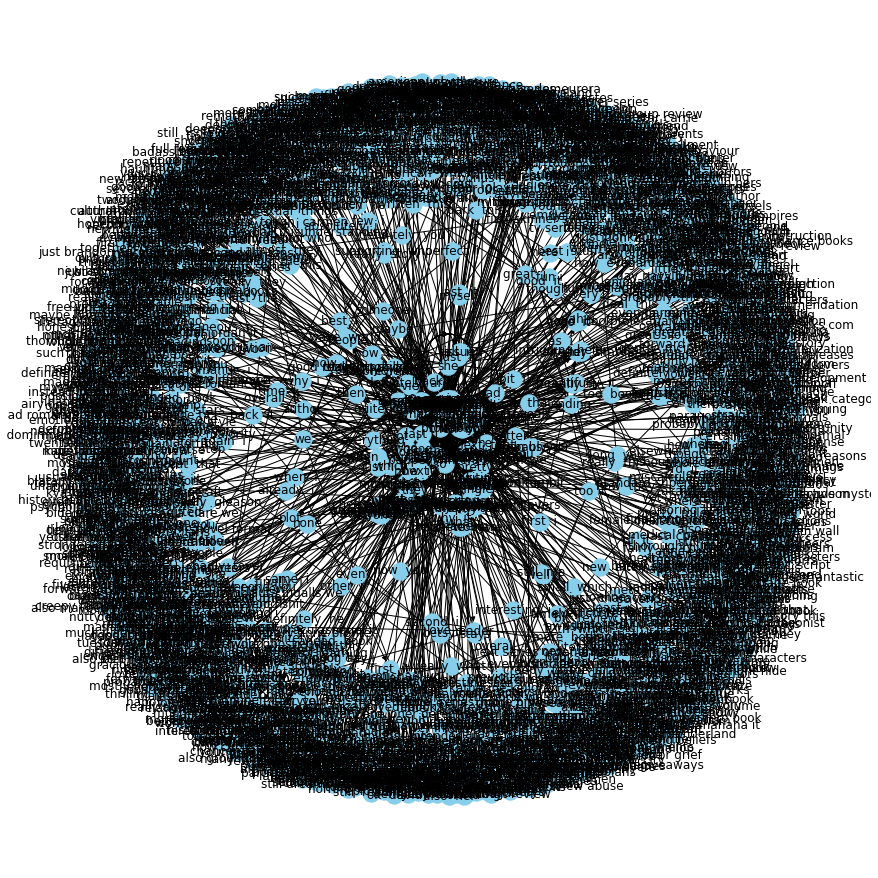

In [26]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

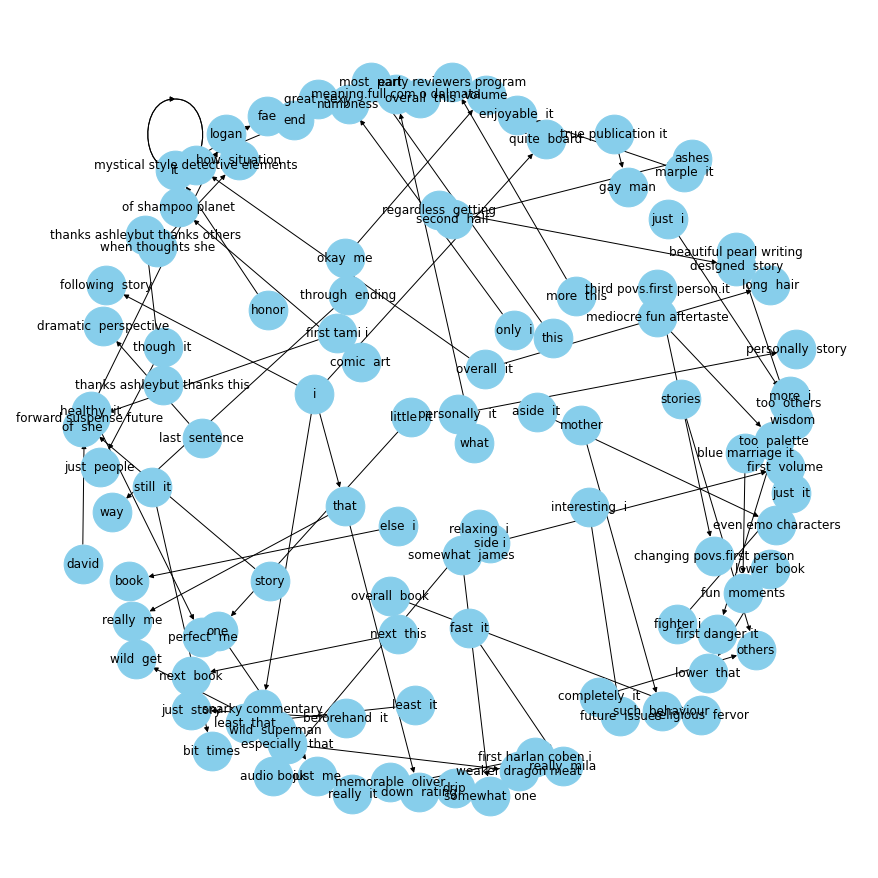

In [26]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes

edge_labels= nx.get_edge_attributes(G,'was')
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()